## Imports

In [49]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import dataframe_image as dfi
import plotly.express as px
import plotly.graph_objects as go
from scipy.signal import periodogram, welch
from scipy import signal
from scipy import integrate
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

#ReliefF
from skrebate import ReliefF
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

warnings.filterwarnings('ignore')

In [37]:
dir_files = '../Dataset/'
col_labels = [
    'Dev Id',
    'Acc X',
    'Acc Y',
    'Acc Z',
    'Gyr X',
    'Gyr Y',
    'Gyr Z',
    'Mag X',
    'Mag Y',
    'Mag Z',
    'Timestamp',
    'Label'
]

act_labels = np.array([
    'Stand',
    'Sit',
    'Sit and Talk',
    'Walk',
    'Walk and Talk',
    'Climb Stairs (CS)',
    'CS and Talk',
    'Stand to Sit',
    'Sit to Stand',
    'Stand to Sit and Talk',
    'Sit to Stand and Talk',
    'Stand to Walk',
    'Walk to Stand',
    'Stand to CS/CS and Talk',
    'CS to Walk',
    'CS and Talk to Walk and Talk'
])

modules_labels = [
    'N Total',
    'N Outliers',
    'Density'
]

sensors = [
    'Acc',
    'Gyr',
    'Mag'
]

k_values = [
    3,
    3.5,
    4
]

acts = np.array([
    1,
    8,
    14
])

f = 51.2

plot_colors = px.colors.qualitative.Light24

# Exercício 2: Read Files

In [3]:
def read_file(n_ids=1, dev=2):
    dfs = []
    for id in range(n_ids):
        file_path = dir_files + 'part' + str(id) + '/part' + str(id) + 'dev' + str(dev) + '.csv'

        csv_file = open(file_path)
        csv_reader = csv.reader(csv_file, delimiter=',')
        data_np = np.array(list(csv_reader)).astype(float)

        data = pd.DataFrame(data_np)
        data.columns = col_labels
        
        dfs.append(data)
        
    data = pd.concat(dfs,axis=0)
    data['Label'] = data['Label'].astype(int)
    labels = act_labels[data['Label'].astype(int)-1]
    data['Label Name'] = labels
#     data['Label'] = pd.Series((data['Label']).astype(int))
    return data
    

data = read_file()
display(data)

,Dev Id,Acc X,Acc Y,Acc Z,Gyr X,Gyr Y,Gyr Z,Mag X,Mag Y,Mag Z,Timestamp,Label,Label Name
0,2.0,3.0317,9.0450,3.1739,0.762470,3.70710,-0.313840,0.57764,0.68849,1.26540,63.629,1,Stand
1,2.0,2.9591,9.0436,3.1400,0.405880,4.66820,-0.101480,0.58385,0.68849,1.27410,83.160,1,Stand
2,2.0,2.9465,9.0545,3.0799,0.242300,5.52250,0.348570,0.56522,0.67857,1.26750,102.690,1,Stand
3,2.0,2.7898,9.0528,3.0726,0.498580,6.34630,0.611270,0.56108,0.65476,1.26100,122.220,1,Stand
4,2.0,2.6924,9.0377,2.9794,0.631970,6.69720,1.005600,0.57764,0.69246,1.26750,141.750,1,Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52859,2.0,2.3837,9.0681,3.4339,-0.429610,-1.75440,-0.300480,0.35197,0.88294,0.69737,1039200.000,1,Stand
52860,2.0,2.4075,8.9945,3.3985,-0.279800,-1.72390,0.129850,0.35197,0.86706,0.69079,1039200.000,1,Stand
52861,2.0,2.3837,9.0316,3.4346,-0.043147,-0.77803,0.195980,0.32919,0.84722,0.69956,1039300.000,1,Stand
52862,2.0,2.3236,9.0922,3.4472,-0.125830,-0.56445,-0.016121,0.33747,0.88889,0.70614,1039300.000,1,Stand


# Exercício 3.1: Modules

In [4]:
def calc_mod(data):
    acc = np.sqrt((data['Acc X']**2 + data['Acc Y']**2 + data['Acc Z']**2))
    gyr = np.sqrt((data['Gyr X']**2 + data['Gyr Y']**2 + data['Gyr Z']**2))
    mag = np.sqrt((data['Mag X']**2 + data['Mag Y']**2 + data['Mag Z']**2))
    
    frame = {
        'Dev Id': data['Dev Id'].astype(int),
        'Acc': acc,
        'Gyr': gyr,
        'Mag': mag,
        'Timestamp': data['Timestamp'],
        'Label': data['Label'],
        'Label Name': data['Label Name']
    }
    data = pd.DataFrame(frame)
    display(data)
    return data

data_mod = calc_mod(data)

,Dev Id,Acc,Gyr,Mag,Timestamp,Label,Label Name
0,2,10.053699,3.797690,1.552071,63.629,1,Stand
1,2,10.020108,4.686910,1.561483,83.160,1,Stand
2,2,10.007578,5.538792,1.544826,102.690,1,Stand
3,2,9.958767,6.395135,1.527626,122.220,1,Stand
4,2,9.889685,6.801699,1.555547,141.750,1,Stand
...,...,...,...,...,...,...,...
52859,2,9.985196,1.831058,1.178894,1039200.000,1,Stand
52860,2,9.911957,1.751280,1.163128,1039200.000,1,Stand
52861,2,9.952301,0.803493,1.146966,1039300.000,1,Stand
52862,2,9.997520,0.578530,1.184333,1039300.000,1,Stand


# Exercício 3.2: Density

In [5]:
def get_density_outliers(data_act,vec_name):
    k=1.5
    column = vec_name

    quart = data_act[column].quantile([0.25,0.75])
    iqr = quart[0.75] - quart[0.25]
    lim = [quart[0.25] - k*iqr, quart[0.75] + k*iqr]

    outliers = data_act.loc[(data_act[column] < lim[0]) | (data_act[column] > lim[1])]
    not_outliers = data_act.loc[(data_act[column] >= lim[0]) & (data_act[column] <= lim[1])]

    return [outliers,not_outliers]

def getDensity(data_act,vec_name):
    outliers = get_density_outliers(data_act,vec_name)[0]

    n = data_act.shape[0]

    return [outliers.shape[0] / n * 100, n, outliers.shape[0]]  #densidade, nº de pontos, nº de outliers

def plotBoxplot(data,vec_name):
    fig = px.box(data, x=data.loc[data['Label'].isin(acts)]['Label Name'], y=data.loc[data['Label'].isin(acts)][vec_name], color=data.loc[data['Label'].isin(acts)]['Label'], title=vec_name + ' Boxplot ' + ", ".join(act_labels[acts]), color_discrete_sequence=plot_colors)
    fig.update_traces(quartilemethod="linear", jitter=0,marker=dict(size=4))
    fig.show()
    
    fig = px.box(data, x="Label Name", y=vec_name, color="Label Name", title=vec_name + ' Boxplot All Activities', color_discrete_sequence=plot_colors)
    fig.update_traces(quartilemethod="linear", jitter=0,marker=dict(size=4))
    fig.show()
    
def plot_bar(data):
    for vec_name in sensors:
        fig = px.bar(data, x='Label Name', y=vec_name + ' Density', color='Label Name',title=vec_name + ' Outliers Density By Activity', color_discrete_sequence=plot_colors)
        fig.show()

def evaluateDensity(data,n_acts=16):
    density = [pd.DataFrame(np.arange(1,n_acts+1)),pd.DataFrame(act_labels)]
    density[0].columns = ['Label']
    density[1].columns = ['Label Name']
    
    for vec_name in sensors:
        values = [[],[],[]]
        for act in range(1,n_acts+1):
            data_act = data.loc[data['Label'] == act]
            [dens,n,n_out] = getDensity(data_act,vec_name)
            values[0].append(n)
            values[1].append(n_out)
            values[2].append(dens)

        for i in range(0,len(values)):
            values[i] = pd.DataFrame(values[i])
            values[i].columns = [vec_name + ' ' + modules_labels[i]]

        values = pd.concat(values,axis=1)
#         plotBoxplot(data,vec_name)
        density += [values]

    density = pd.concat(density,axis=1)
    density.index = np.arange(1,n_acts+1)
    
#     plot_bar(density)
    
    return density

density = evaluateDensity(data_mod)
display(density)

,Label,Label Name,Acc N Total,Acc N Outliers,Acc Density,Gyr N Total,Gyr N Outliers,Gyr Density,Mag N Total,Mag N Outliers,Mag Density
1,1,Stand,11012,762,6.919724,11012,902,8.191064,11012,12,0.108972
2,2,Sit,5760,201,3.489583,5760,368,6.388889,5760,0,0.000000
3,3,Sit and Talk,5760,357,6.197917,5760,324,5.625000,5760,45,0.781250
4,4,Walk,8706,363,4.169538,8706,26,0.298645,8706,106,1.217551
5,5,Walk and Talk,9474,192,2.026599,9474,117,1.234959,9474,12,0.126662
6,6,Climb Stairs (CS),6529,209,3.201103,6529,76,1.164037,6529,0,0.000000
7,7,CS and Talk,2817,50,1.774938,2817,45,1.597444,2817,0,0.000000
8,8,Stand to Sit,384,116,30.208333,384,51,13.281250,384,55,14.322917
9,9,Sit to Stand,384,63,16.406250,384,63,16.406250,384,43,11.197917
10,10,Stand to Sit and Talk,384,99,25.781250,384,70,18.229167,384,69,17.968750


# Exercício 3.4: Z-Score

In [6]:
def plotZscore(data,vec_name):
    for act in acts:
        data_act = data.loc[data['Label'] == act,vec_name]
        fig = go.Figure()
        for k in k_values:
            [outliers,not_outliers] = zscore(data_act, data_act.mean(), data_act.std(), k)
            
            fig.add_trace(go.Scatter(x=np.full(outliers.shape[0],k), y=outliers,
                                mode='markers',
                                name='Outliers k=' + str(k), marker_color='red'))
            
            fig.add_trace(go.Scatter(x=np.full(not_outliers.shape[0],k), y=not_outliers,
                                mode='markers',
                                name='Not Outliers k=' + str(k), marker_color='blue'))
            
        fig.add_trace(go.Box(x=np.full(data_act.shape[0],4.5),y=data_act))
        fig.update_layout(title=vec_name + ' Zscore vs Boxplot ' + act_labels[act-1])
        fig.update_traces(marker=dict(size=3))
        fig.show()

def zscore(data, mean, std,k):
    z = (data - mean) / std
    
    out_pos = z.loc[(z < -k) | (z > k)].index
    not_out_pos = z.loc[(z >= -k) & (z <= k)].index

    out = data.loc[out_pos]
    not_out = data.loc[not_out_pos]

    return [out,not_out]

def outliersZscore(density,data,vec_name,n_act=16):
    column = vec_name
    n_outliers = list() 
        
    for act in range(1,n_act+1):
        k_out = list()
        for k in k_values:
            data_act = data.loc[data['Label'] == act,column]
            [out,not_out] = zscore(data_act, data_act.mean(), data_act.std(), k)

            k_out.append(out.shape[0])

        df = pd.DataFrame(k_out)
        df.columns = [act]
        df.index = k_values
        n_outliers.append(df)

    n_outliers = pd.concat(n_outliers,axis=1)
    n_outliers = n_outliers.transpose()
    
    data_zscore = pd.concat([density[['Label','Label Name',vec_name + ' N Total',vec_name + ' N Outliers']],n_outliers],axis=1)
    data_zscore = data_zscore.rename(columns = {vec_name + ' N Outliers': vec_name + ' Out Boxplot'})

    for k in k_values:
        data_zscore = data_zscore.rename(columns={k: 'Z-score k=' + str(k)})

#     plotZscore(data,vec_name)
    
    return data_zscore

acc_zscore = outliersZscore(density,data_mod,'Acc')
gyr_zscore = outliersZscore(density,data_mod,'Gyr')
mag_zscore = outliersZscore(density,data_mod,'Mag')

display(acc_zscore)
display(gyr_zscore)
display(mag_zscore)

,Label,Label Name,Acc N Total,Acc Out Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
1,1,Stand,11012,762,128,109,98
2,2,Sit,5760,201,71,52,43
3,3,Sit and Talk,5760,357,76,59,47
4,4,Walk,8706,363,105,38,19
5,5,Walk and Talk,9474,192,49,13,7
6,6,Climb Stairs (CS),6529,209,39,24,12
7,7,CS and Talk,2817,50,11,4,3
8,8,Stand to Sit,384,116,6,6,4
9,9,Sit to Stand,384,63,12,9,3
10,10,Stand to Sit and Talk,384,99,9,9,7


,Label,Label Name,Gyr N Total,Gyr Out Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
1,1,Stand,11012,902,211,187,169
2,2,Sit,5760,368,66,54,43
3,3,Sit and Talk,5760,324,116,86,59
4,4,Walk,8706,26,15,7,4
5,5,Walk and Talk,9474,117,72,35,19
6,6,Climb Stairs (CS),6529,76,43,29,19
7,7,CS and Talk,2817,45,22,4,3
8,8,Stand to Sit,384,51,4,0,0
9,9,Sit to Stand,384,63,14,9,1
10,10,Stand to Sit and Talk,384,70,11,0,0


,Label,Label Name,Mag N Total,Mag Out Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
1,1,Stand,11012,12,0,0,0
2,2,Sit,5760,0,0,0,0
3,3,Sit and Talk,5760,45,20,3,0
4,4,Walk,8706,106,0,0,0
5,5,Walk and Talk,9474,12,0,0,0
6,6,Climb Stairs (CS),6529,0,0,0,0
7,7,CS and Talk,2817,0,0,0,0
8,8,Stand to Sit,384,55,1,0,0
9,9,Sit to Stand,384,43,17,5,0
10,10,Stand to Sit and Talk,384,69,11,3,0


# Exercício 3.7: Outliers com k-means

Act 9
  Clust 7
Act 10
  Clust 4


,Label Name,N Clusters,N Outliers,Acc Out Boxplot,Z-score k=3,Z-score k=3.5,Z-score k=4
9,Sit to Stand,7,17,63,12,9,3
10,Stand to Sit and Talk,4,28,99,9,9,7


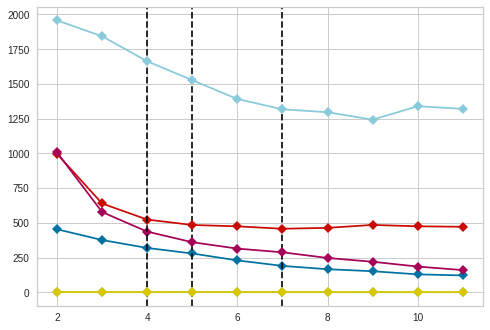

In [7]:
def best_k(data,vec_name,act,vis=False):
    best_v = []
    
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric='distortion', timings=False, locate_elbow=True, title='Elbow Method to ' + act_labels[act-1] + 'With Distortion')
    x = data.loc[data['Label'] == act,[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].to_numpy()
    visualizer.fit(x)        # Fit the data to the visualizer
    if(vis):
        visualizer.show()
    best_dist = visualizer.elbow_value_
    if(best_dist != None):
        best_v.append(best_dist)
    
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric='silhouette', timings=False, locate_elbow=True, title='Elbow Method to ' + act_labels[act-1] + 'With Silhouette')
    x = data.loc[data['Label'] == act,[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].to_numpy()
    visualizer.fit(x)        # Fit the data to the visualizer
    if(vis):
        visualizer.show()
    best_sil = visualizer.elbow_value_
    if(best_sil != None):
        best_v.append(best_sil)
    
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric='calinski_harabasz', timings=False, locate_elbow=True, title='Elbow Method to ' + act_labels[act-1] + 'With Calinski')
    x = data.loc[data['Label'] == act,[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].to_numpy()
    visualizer.fit(x)        # Fit the data to the visualizer
    if(vis):
        visualizer.show()
    best_cal = visualizer.elbow_value_
    if(best_cal != None):
        best_v.append(best_cal)
    
    if(best_v == []):
        return 6
    return best_v[0]
        
def assign_clusters(data, centroids):
    for index, row in data.iterrows():
        for i in range(len(centroids)):
            d_compare = np.sqrt((row['X'] - centroids[i][0])**2 + (row['Y'] - centroids[i][1])**2 + (row['Z'] - centroids[i][2])**2)
            if (data.loc[index, 'Distance'] == -1 or data.loc[index, 'Distance'] > d_compare):
                data.loc[index, 'Clusters'] = i
                data.loc[index, 'Distance'] = d_compare
    return data

def update_centroids(data, centroids):
    for i in range(len(centroids)):
        centroids[i][0] = data['X'].loc[data['Clusters'] == i].mean()
        centroids[i][1] = data['Y'].loc[data['Clusters'] == i].mean()
        centroids[i][2] = data['Z'].loc[data['Clusters'] == i].mean()
    
    return centroids
        
def k_means(n_clusters, data):
    centroids = [[] for _ in range(n_clusters)]
    
    for i in range(n_clusters):
        centroids[i] = data.sample().to_numpy()[0]
        
    data['Clusters'] = -1
    data['Distance'] = -1
    prev_clusters = data['Clusters'].copy()
    
    while(True):
        data = assign_clusters(data, centroids)
        
        if (data['Clusters'].equals(prev_clusters)):
            break
            
        centroids = update_centroids(data, centroids)
        prev_clusters = data['Clusters'].copy()
        
    return [data, centroids]

def clusters_kmeans(n_clusters, data, act, vec_name):
    data = data.loc[data['Label'] == act]
    
    xyz = data[[vec_name + ' X', vec_name + ' Y', vec_name + ' Z']]
    xyz = xyz.rename(columns={vec_name + " X":"X", vec_name + " Y":"Y", vec_name + " Z":"Z"})
    
    [xyz, centroids] = k_means(n_clusters, xyz)

    return xyz
    
def plot_cluster(clusters,out,vec_name,act):
    data = clusters.copy()
    
    data['Clusters'] += 1
    data['Clusters'][data.loc[data['Clusters'] == out+1].index] = 'outliers'
    
    fig = px.scatter_3d(data, x='X', y='Y', z='Z', color=data['Clusters'].astype(str), title=vec_name + ' Clusters Act ' + act_labels[act-1] + ' N Clusters=' + str(data['Clusters'].unique().shape[0]),color_discrete_sequence=plot_colors)
    fig.update_traces(marker=dict(size=3))
    fig.show()
    
def outliers_kmeans(data,zscore,vec_name,acts=[10],min_clust=2,max_clust=7,n_act=16):
    acts = np.array(acts)
    elbow = np.full((max_clust-min_clust+1,len(acts)),-1)
    kmeans_vec = np.full((max_clust-min_clust+1,len(acts)),-1)
    values = []
    for i in range(len(acts)):
        act = acts[i]
        act_values=[]
        print('Act',act)
        clust = best_k(data,vec_name,act)
        print('  Clust',clust)
        clusters = clusters_kmeans(clust, data, act, vec_name)
        
        count = clusters['Clusters'].value_counts()
        c = count.index[-1]
        minCluster = clusters.loc[clusters['Clusters'] == c]

        values.append([act_labels[act-1],clust,minCluster.shape[0]])
        
#         plot_cluster(clusters,count.index[-1],vec_name,act)
    
    df = pd.DataFrame(values)
    df.columns = ['Label Name', 'N Clusters', 'N Outliers']
    df.index = acts
    
    clust = pd.concat([df,zscore.loc[zscore['Label'].isin(acts)][zscore.columns[-(1+len(k_values)):]]],axis=1)
    
    return clust

clust_acc = outliers_kmeans(data,acc_zscore,'Acc',[9,10])
display(clust_acc)

# Exercício 3.8

In [8]:
def outlier_injection(data, x, k=3):
    max_iterations = 10
    iterations = 0
    
    data = data.copy()
    
    mean = data.mean()
    std = data.std()
    
    out, non_out = zscore(data, mean, std, k)
    out_dens = out.count()/data.count() * 100
        
    print('Initial density: {:.3f}\tOutliers count: {:d}'.format(out_dens, out.count()))
    
    while (out_dens < 0.99*x and iterations < max_iterations): 
        z = abs(max(out) - (mean + k*std))
        
        d = x - out_dens
        n_points = int(np.ceil(d*data.count() / 100))
        inj_points = non_out.sample(n_points)
        
        for index, value in inj_points.items():
            s = np.random.randint(2)
            if s == 0:
                s = -1
            q = np.random.uniform(0, z)
            data[index] = mean + s*k*(std + q)
        
        out, non_out = zscore(data, mean, std, k)
        out_dens = out.count()/data.count() * 100
        iterations += 1
        print('Iteration: {:d}\tOutlier Density: {:.3f}'.format(iterations, out_dens))
    
    print('Final density: {:.3f}\tOutliers count: {:d}'.format(out_dens, out.count()))
    return [data, out, non_out]

# Exercício 3.9

In [141]:
def linear_model(window, p):
    y = np.matrix([[window[i]] for i in range(p, len(window)) ])
    x = []
    for i in range(p, len(window)):
        aux = [window[i - j] for j in range(1, p+1)]
        aux.insert(0, 1)
        x.append(aux)
    x = np.matrix(x)
    
    return np.squeeze(np.asarray(np.dot(np.linalg.pinv(x), y)))

def linear_model_center(window, p):
    p2 = int(np.floor(p/2))
    
    y = np.matrix([[window[i]] for i in range(p2, len(window)-p2) ])
    x = []
    for i in range(p2, len(window)-p2):
        aux = [window[i - j] for j in range(1, p2+1)]
        aux.reverse()
        aux1 = [window[i + j] for j in range(1, p2+1)]
        aux.extend(aux1)
        aux.insert(0, 1)
        x.append(aux)
    x = np.matrix(x)
    
    return np.squeeze(np.asarray(np.dot(np.linalg.pinv(x), y)))

# Exercício 3.10

In [146]:
window_size = 15
num_p = 10

def LOO(window, p_test, model = 'normal'):
    errors = []
    
    for p in p_test:
        error = 0
        if model == 'normal':
            for i in range(p, len(window)):
                aux = window[:i]
                aux1 = window[i+1:]
                aux.extend(aux1)
                
                betas = linear_model(aux, p)
                
                predicted_value = 0
                predicted_value += betas[0]
                for j in range(1, len(betas)):
                    predicted_value += betas[j]*window[i-j]
                    
                error += np.power(window[i] - predicted_value, 2)
            errors.append(error)
        else:
            for i in range(round(p/2), len(window)-round(p/2)):
                aux = window[:i]
                aux1 = window[i+1:]
                aux.extend(aux1)
                
                betas = linear_model_center(aux, p)
                
                predicted_value = 0
                predicted_value += betas[0]
                for j in range(1, round(len(betas)/2)):
                    predicted_value += betas[j]*window[i-j]
                for j in range(1, round(len(betas)/2)):
                    predicted_value += betas[int(np.floor(len(betas)/2))+j]*window[i+j]
            
                error += np.power(window[i] - predicted_value, 2)
            errors.append(error)
    
#     plt.figure(figsize=(10,10))
#     plt.bar(p_test, errors)
#     plt.plot(p_test, errors, color='red')
    
#     print('Best p value: {:d}'.format(p_test[errors.index(min(errors))]))
    
    return(p_test[errors.index(min(errors))])

Initial density: 1.162	Outliers count: 128
Iteration: 1	Outlier Density: 10.007
Final density: 10.007	Outliers count: 1102


,Real Values,Transformed Values,Predicted Values,Was Predicted,Category
58,9.968760,22.707800,9.96993,True,Outlier
119,10.140024,22.332831,10.0346,True,Outlier
144,10.027991,20.943864,10.0298,True,Outlier
277,9.999789,4.519848,9.9482,True,Outlier
403,9.958742,17.226029,9.87664,True,Outlier
...,...,...,...,...,...
10800,9.982768,0.473897,9.97921,True,Outlier
10822,9.853246,2.788647,9.90184,True,Outlier
10843,10.108096,-4.041256,9.89239,True,Outlier
10865,9.894365,5.701862,10.1802,True,Outlier


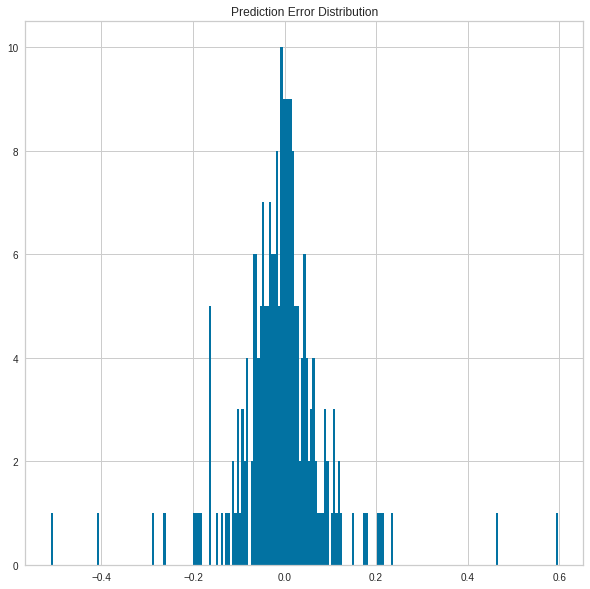

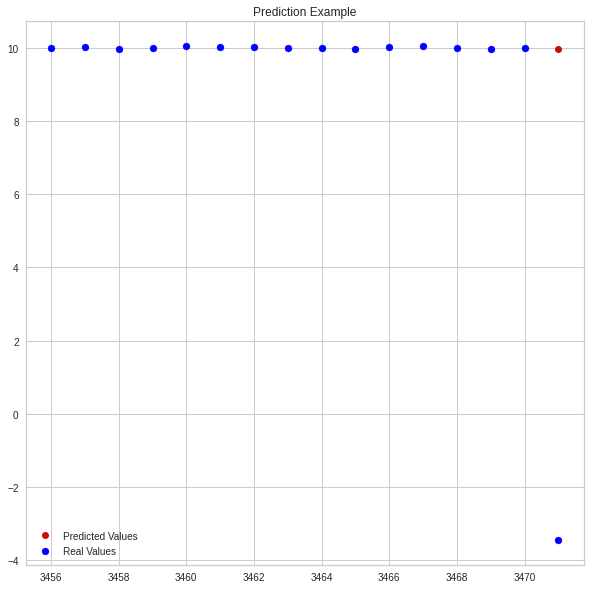

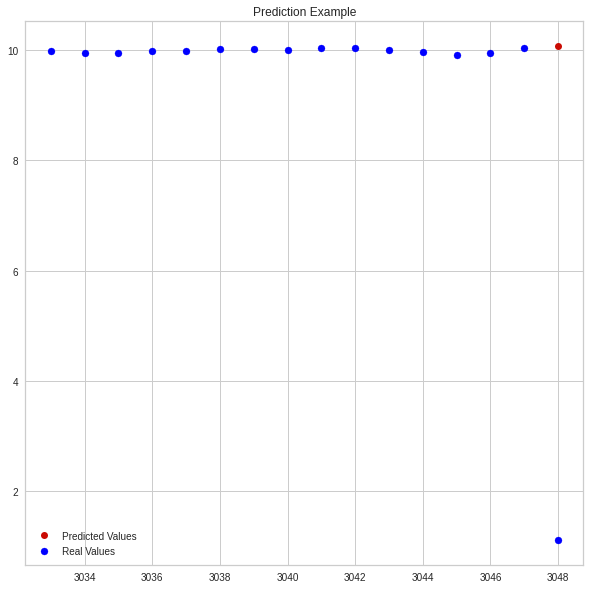

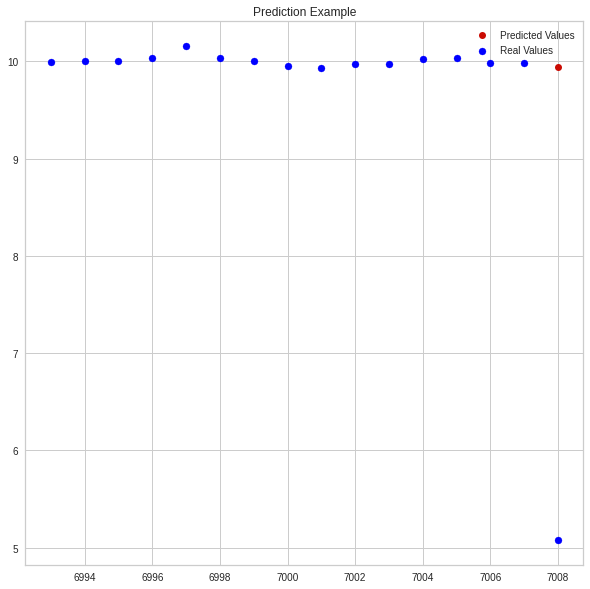

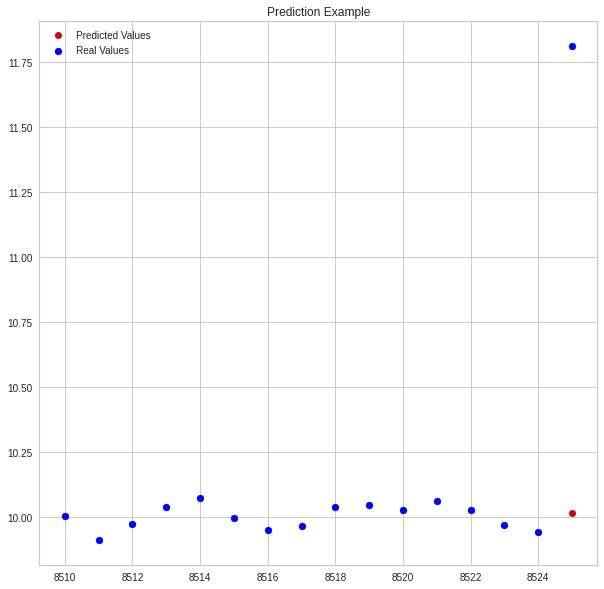

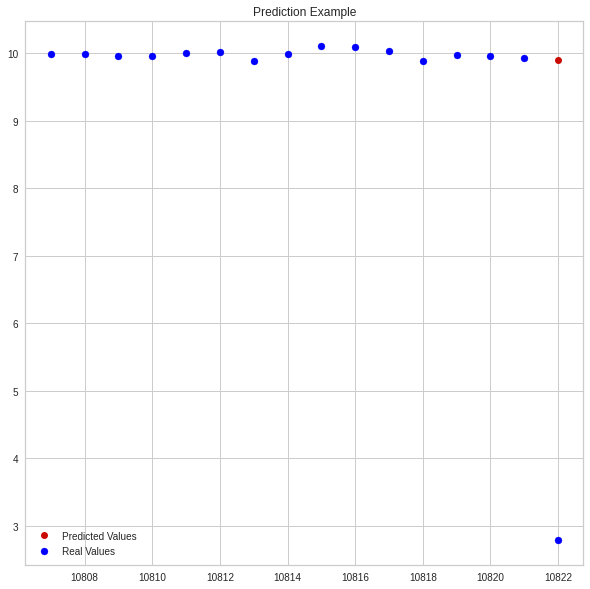

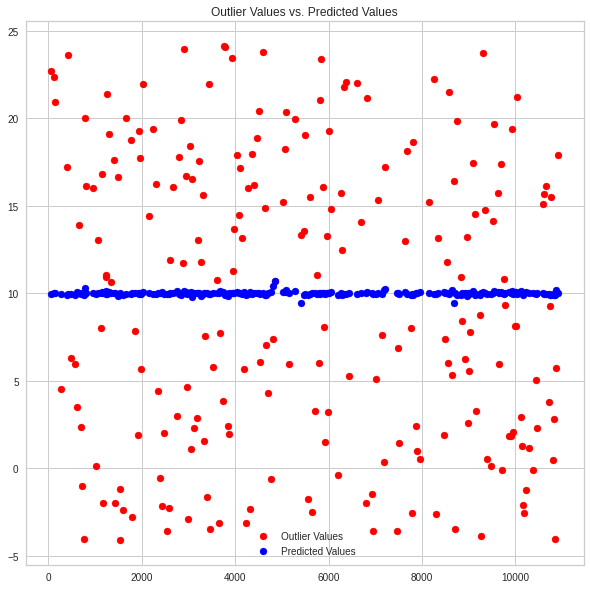

In [159]:
def ex3_10(data):
    [inj_data, outliers, non_outliers] = outlier_injection(data, 10)
    
    frame = {
        'Real Values': data,
        'Transformed Values': inj_data,
        'Predicted Values': None,
        'Was Predicted': [False for _ in range(len(inj_data))],
        'Category': ['Non Outlier' for _ in range(len(inj_data))]
    }
    
    df = pd.DataFrame(frame)
    df.loc[df.index.isin(outliers.index), 'Category'] = 'Outlier'
    df = df.reset_index(drop=True)
    
    for index in df.loc[df['Category'] == 'Outlier'].index.tolist():
        if index < window_size:
            continue
        else:
            window = df.loc[index-window_size-1:index-1]
            
            if not window.loc[window['Category'] == 'Outlier'].empty:
                continue
            
            p = LOO(window['Transformed Values'].tolist(), [i for i in range(1, num_p+1)])
            betas = linear_model(window['Transformed Values'].tolist(), p)
            
            prediction = betas[0]
            for i in range(1, len(betas)):
                prediction += float(betas[i] * df.loc[index-i, ['Transformed Values']])
            df.loc[index, ['Predicted Values']] = prediction
            df.loc[index, ['Was Predicted']] = True
    
    display(df.loc[df['Was Predicted']])
    
    plt.figure(figsize=(10, 10))
    plt.title('Prediction Error Distribution')
    plt.hist(df.loc[df['Was Predicted']]['Real Values']-df.loc[df['Was Predicted']]['Predicted Values'], bins=len(df.loc[df['Was Predicted']]))
    
    outliers_sample = df.loc[df['Was Predicted']].sample(5)
    for index, row in outliers_sample.iterrows():
        window = df[index-window_size:index+1]
        plt.figure(figsize=(10, 10))
        plt.title('Prediction Example')
        plt.scatter(window.index.tolist(), window['Transformed Values'], color='blue', label='Real Values')
        plt.plot(index, row['Predicted Values'], 'ro', label='Predicted Values')
        plt.legend()
    
    plt.figure(figsize=(10, 10))
    plt.title('Outlier Values vs. Predicted Values')
    plt.scatter(df.loc[df['Was Predicted']].index.tolist(), df.loc[df['Was Predicted']]['Transformed Values'], color='red', label='Outlier Values')
    plt.scatter(df.loc[df['Was Predicted']].index.tolist(), df.loc[df['Was Predicted']]['Predicted Values'], color='blue', label='Predicted Values')
    plt.legend()
                    
ex3_10(data_mod.loc[data_mod['Label'] == 1]['Acc'])

# Exercício 3.11

Initial density: 1.162	Outliers count: 128
Iteration: 1	Outlier Density: 10.007
Final density: 10.007	Outliers count: 1102


,Real Values,Transformed Values,Predicted Values,Was Predicted,Category
24,10.064841,14.624584,10.0465,True,Outlier
50,9.987038,23.342895,9.97966,True,Outlier
99,10.111654,10.689309,9.98777,True,Outlier
171,9.994757,0.766959,9.94274,True,Outlier
200,10.069149,5.447991,9.9981,True,Outlier
...,...,...,...,...,...
10815,10.110444,-1.058679,9.99606,True,Outlier
10827,10.000933,-1.056089,10.0078,True,Outlier
10840,10.021790,15.508057,9.99582,True,Outlier
10856,9.947142,11.348585,9.95737,True,Outlier


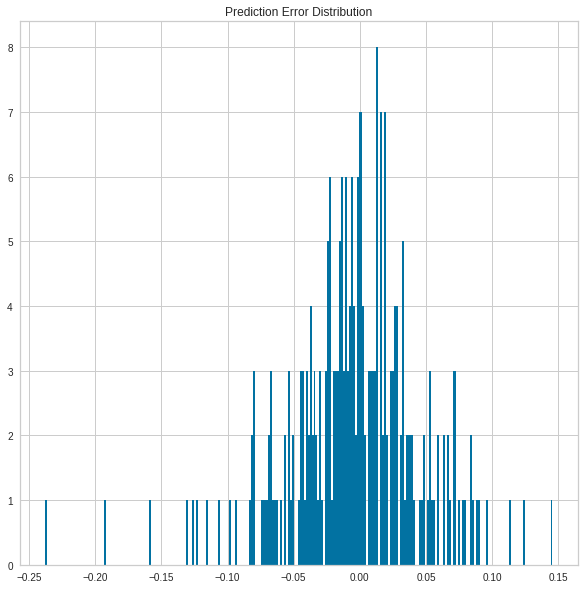

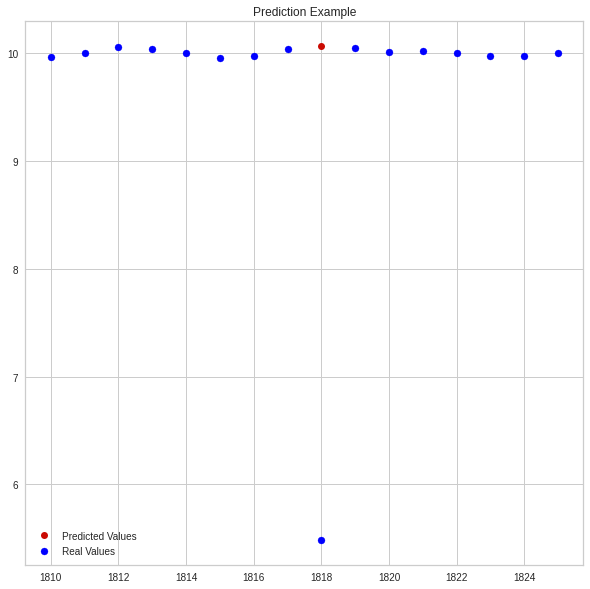

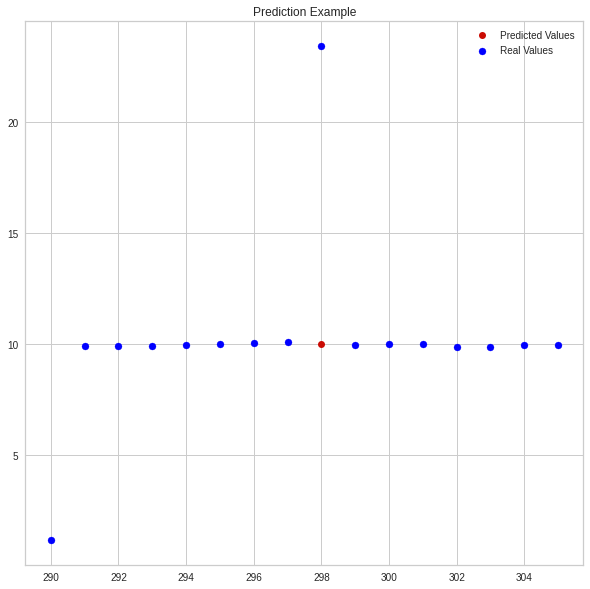

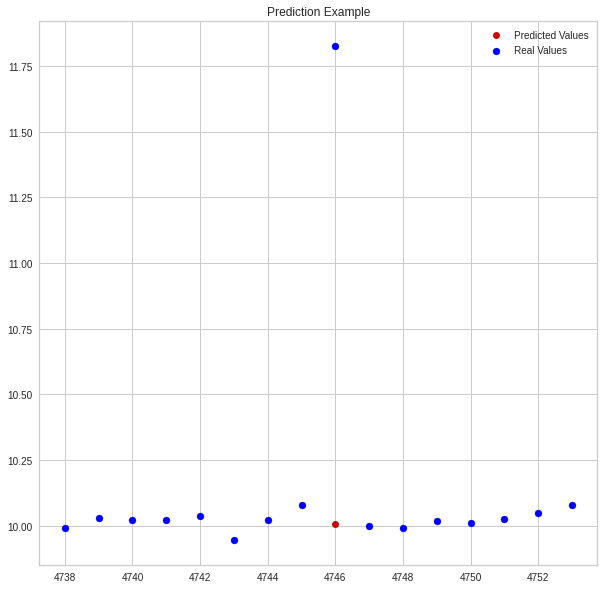

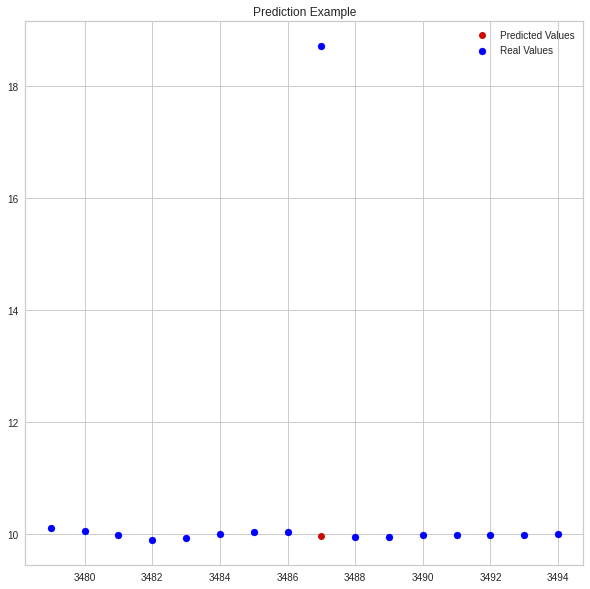

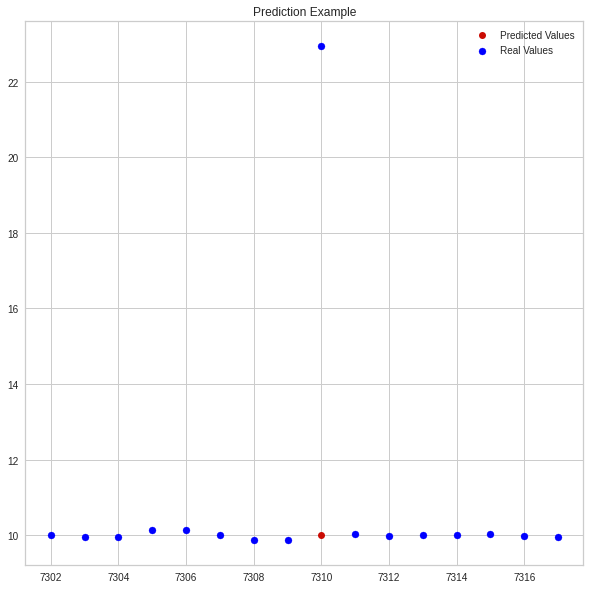

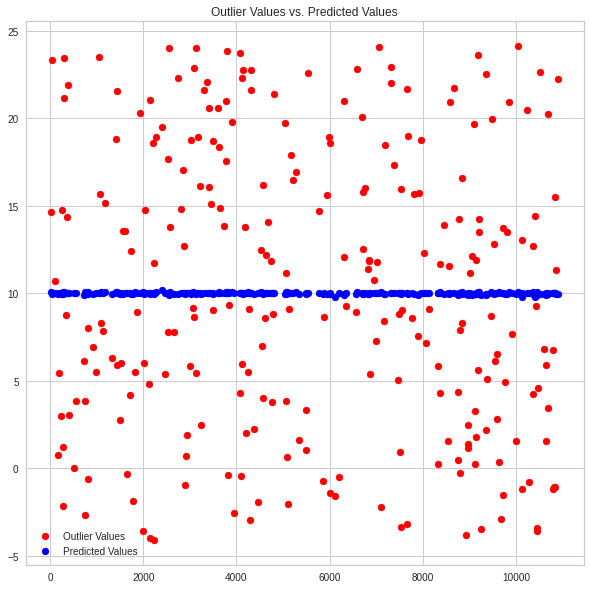

In [158]:
def ex3_11(data):
    [inj_data, outliers, non_outliers] = outlier_injection(data, 10)
    
    frame = {
        'Real Values': data,
        'Transformed Values': inj_data,
        'Predicted Values': None,
        'Was Predicted': [False for _ in range(len(inj_data))],
        'Category': ['Non Outlier' for _ in range(len(inj_data))]
    }
    
    df = pd.DataFrame(frame)
    df.loc[df.index.isin(outliers.index), 'Category'] = 'Outlier'
    df = df.reset_index(drop=True)
    
    for index in df.loc[df['Category'] == 'Outlier'].index.tolist():
        if index < int(np.floor(window_size/2)):
            continue
        else:
            window = df.loc[index-int(np.floor(window_size/2)):index-1]
            aux_window = df.loc[index+1:index+int(np.floor(window_size/2))]
            
            window = window.append(aux_window)
            
            if not (window.loc[window['Category'] == 'Outlier'].empty) :
                continue
            
            p = LOO(window['Transformed Values'].tolist(), [i for i in range(3, num_p+1, 2)], 'centered')
            betas = linear_model_center(window['Transformed Values'].tolist(), p)
            
            prediction = betas[0]
            values = df.loc[index-(len(betas)/2):index-1]
            values = values.append(df.loc[index+1:index+(len(betas)/2)])
            for i in range(1, len(betas)):
                prediction += float(betas[i] * values['Transformed Values'].tolist()[i-1])
            df.loc[index, ['Predicted Values']] = prediction
            df.loc[index, ['Was Predicted']] = True
    
    display(df.loc[df['Was Predicted']])
    
    plt.figure(figsize=(10, 10))
    plt.title('Prediction Error Distribution')
    plt.hist(df.loc[df['Was Predicted']]['Real Values']-df.loc[df['Was Predicted']]['Predicted Values'], bins=len(df.loc[df['Was Predicted']]))
    
    outliers_sample = df.loc[df['Was Predicted']].sample(5)
    for index, row in outliers_sample.iterrows():
        window = df[index-round(window_size/2):index+round(window_size/2)]
        plt.figure(figsize=(10, 10))
        plt.title('Prediction Example')
        plt.scatter(window.index.tolist(), window['Transformed Values'], color='blue', label='Real Values')
        plt.plot(index, row['Predicted Values'], 'ro', label='Predicted Values')
        plt.legend()
    
    plt.figure(figsize=(10, 10))
    plt.title('Outlier Values vs. Predicted Values')
    plt.scatter(df.loc[df['Was Predicted']].index.tolist(), df.loc[df['Was Predicted']]['Transformed Values'], color='red', label='Outlier Values')
    plt.scatter(df.loc[df['Was Predicted']].index.tolist(), df.loc[df['Was Predicted']]['Predicted Values'], color='blue', label='Predicted Values')
    plt.legend()
         
ex3_11(data_mod.loc[data_mod['Label'] == 1]['Acc'])

# Exercício 4.1

In [13]:
def ex4_1(data):
    df = data.copy()
    acts = df['Label'].sort_values().unique()
    
    for i in range(len(acts)):
        df_acc = df.loc[df['Label'] == acts[i]]['Acc']
        df_gyr = df.loc[df['Label'] == acts[i]]['Gyr']
        df_mag = df.loc[df['Label'] == acts[i]]['Mag']
    
        ks_stats_acc, p_value_acc = stats.kstest(df_acc, 'norm', (df_acc.mean(), df_acc.std()))
        ks_stats_gyr, p_value_gyr = stats.kstest(df_gyr, 'norm', (df_gyr.mean(), df_gyr.std()))
        ks_stats_mag, p_value_mag = stats.kstest(df_mag, 'norm', (df_mag.mean(), df_mag.std()))
    
        print('\nActivity: {:s} ({:d})'.format(act_labels[i], int(acts[i])))
        print('Accelerator Module\nKS statistic: ', ks_stats_acc,'\tP value: ', p_value_acc)
        print('Gyroscope Module\nKS statistic: ', ks_stats_gyr,'\tP value: ', p_value_gyr)
        print('Magnetometer Module\nKS statistic: ', ks_stats_mag,'\tP value: ', p_value_mag)
        
ex4_1(data_mod)


Activity: Stand (1)
Accelerator Module
KS statistic:  0.2795907823869306 	P value:  0.0
Gyroscope Module
KS statistic:  0.3590710211246676 	P value:  0.0
Magnetometer Module
KS statistic:  0.16367529222610222 	P value:  2.9574470412152124e-258

Activity: Sit (2)
Accelerator Module
KS statistic:  0.12885751383761346 	P value:  7.6768381606937935e-84
Gyroscope Module
KS statistic:  0.2755456731761306 	P value:  0.0
Magnetometer Module
KS statistic:  0.10718044642761915 	P value:  4.476684570053333e-58

Activity: Sit and Talk (3)
Accelerator Module
KS statistic:  0.14310682601639754 	P value:  2.1434834794456207e-103
Gyroscope Module
KS statistic:  0.14576745660008594 	P value:  2.811399310901403e-107
Magnetometer Module
KS statistic:  0.024888993937678294 	P value:  0.0015642353570509229

Activity: Walk (4)
Accelerator Module
KS statistic:  0.08131124352023544 	P value:  1.618560092191503e-50
Gyroscope Module
KS statistic:  0.03287518762363071 	P value:  1.3091214759550656e-08
Magnetome

# Exercício 4.2

In [6]:
data_init = read_file()
display(data_init)


######################################### STATISTICAL

def mean(window,vec_name):
    return [window[vec_name + ' X'].mean(), window[vec_name + ' Y'].mean(), window[vec_name + ' Z'].mean()]

def median(window,vec_name):
    return [window[vec_name + ' X'].median(), window[vec_name + ' Y'].median(), window[vec_name + ' Z'].median()]

def std(window,vec_name):
    return [window[vec_name + ' X'].std(), window[vec_name + ' Y'].std(), window[vec_name + ' Z'].std()]

def variance(window,vec_name):
    return [window[vec_name + ' X'].var(), window[vec_name + ' Y'].var(), window[vec_name + ' Z'].var()]

def rms(window,vec_name):
    x = ((window[vec_name + ' X'] ** 2).sum() / window.shape[0])**0.5
    y = ((window[vec_name + ' Y'] ** 2).sum() / window.shape[0])**0.5
    z = ((window[vec_name + ' Z'] ** 2).sum() / window.shape[0])**0.5
    return [x, y, z]

def ad(window,vec_name):
    x = window[vec_name + ' X'].diff() * f
    y = window[vec_name + ' Y'].diff() * f
    z = window[vec_name + ' Z'].diff() * f
    
    return [x.sum() / x.shape[0], y.sum() / x.shape[0], z.sum() / x.shape[0]]

def skewness(window,vec_name):
    return [window[vec_name + ' X'].skew(), window[vec_name + ' Y'].skew(), window[vec_name + ' Z'].skew()]

def kurtosis(window,vec_name):
    return [window[vec_name + ' X'].kurtosis(), window[vec_name + ' Y'].kurtosis(), window[vec_name + ' Z'].kurtosis()]

def iqr(window,vec_name):
    x = window[vec_name + ' X'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    y = window[vec_name + ' Y'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    z = window[vec_name + ' Z'].quantile(0.75) - window[vec_name + ' X'].quantile(0.25)
    return [x, y, z]

def zcr_mcr(window,vec_name):
    x_zcr = 0
    y_zcr = 0
    z_zcr = 0

    x_mcr = 0
    y_mcr = 0
    z_mcr = 0
    
    [x_mean,y_mean,z_mean] = mean(window,vec_name)

    for i in range(len(window.index)-1):
        index1 = window.index[i]
        index2 = window.index[i+1]

        if(window[vec_name + ' X'][index1] * window[vec_name + ' X'][index2] < 0):
            x_zcr += 1
        if(window[vec_name + ' Y'][index1] * window[vec_name + ' Y'][index2] < 0):
            y_zcr += 1
        if(window[vec_name + ' Z'][index1] * window[vec_name + ' Z'][index2] < 0):
            z_zcr += 1

        if((window[vec_name + ' X'][index1] - x_mean) * ((window[vec_name + ' X'][index2] - x_mean)) < 0):
            x_mcr += 1
        if((window[vec_name + ' Y'][index1] - y_mean) * ((window[vec_name + ' Y'][index2] - y_mean)) < 0):
            y_mcr += 1
        if((window[vec_name + ' Z'][index1] - z_mean) * ((window[vec_name + ' Z'][index2] - z_mean))):
            z_mcr += 1

    return [x_zcr, y_zcr, z_zcr, x_mcr, y_mcr, z_mcr]

def par_corr(window):
    corr_df = window.corr()
    cols = corr_df.columns
    
    corr = []
    for i in range(cols.shape[0]):
        for j in range(i+1,cols.shape[0]):
            corr.append(corr_df[cols[i]][cols[j]])
            
    return corr

def spectral_entropy(x, sf=f, method='fft', nperseg=None, normalize=False):
    # https://raphaelvallat.com/entropy/build/html/generated/entropy.spectral_entropy.html
    x = np.array(x)
    if method == 'fft':
        _, psd = periodogram(x, sf)
    elif method == 'welch':
        _, psd = welch(x, sf, nperseg=nperseg)
    psd_norm = np.divide(psd[np.where(psd != 0)], psd.sum())
    se = -np.multiply(psd_norm, np.log2(psd_norm)).sum()
    if normalize:
        se /= np.log2(psd_norm.size)
    return se

def spec_ent(window,vec_name):
    x = spectral_entropy(window[vec_name + ' X'])
    y = spectral_entropy(window[vec_name + ' Y'])
    z = spectral_entropy(window[vec_name + ' Z'])
    return [x, y, z]

######################################### TEMPORAL

def mov_int(window,vec_name):
    mi = np.sqrt(window[vec_name + ' X']**2 + window[vec_name + ' Y']**2 + window[vec_name + ' Z']**2)
    
    ai = mi.sum() / mi.shape[0]
    vi= ((mi - ai)**2).sum() / mi.shape[0]

    return [ai,vi]

def nor_sig(window,vec_name):
    window['sma'] = window[vec_name + ' X'].abs() + window[vec_name + ' Y'].abs() + window[vec_name + ' Z'].abs()
    
    sma = window['sma'].sum() / window.shape[0]
      
    return [sma]

def eva(window,vec_name):
    x_cov = window[[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].cov()
    eig_values = sorted(np.linalg.eig(x_cov)[0])
    
    return [eig_values[-1],eig_values[-2]]
    
#     sma = window['sma'].sum() / window.shape[0]
      
    return [0]

def cagh(window,vec_name):
    heading = np.sqrt(window[vec_name + ' Y']**2 + window[vec_name + ' Z']**2)
    gravity = window[vec_name + ' X']
    
    corr = par_corr(pd.DataFrame([heading,gravity]).transpose()) 
    return corr

def velocity(window,vec_name):
    v_x = []
    v_y = []
    v_z = []
    x = window[vec_name + ' X']
    y = window[vec_name + ' Y']
    z = window[vec_name + ' Z']
    for i in range(len(window.index)-1):
        index1 = window.index[i]
        index2 = window.index[i+1]
        
        v_x.append((x[index1] + x[index2]) / (2 * f))
        v_y.append((y[index1] + y[index2]) / (2 * f))
        v_z.append((z[index1] + z[index2]) / (2 * f))
        
    return [v_x,v_y,v_z]

def avh_avg(window,vec_name):
    [v_x, v_y, v_z] = velocity(window,vec_name)
    
    v_h = np.sqrt(np.power(v_y,2) + np.power(v_z,2))
    
    return [np.mean(v_h),np.mean(v_x)]

######################################### SPECTRAL
    
def dom_freq(window,vec_name):
    freqs, x = signal.welch(window[vec_name + ' X'], f)
    max_x = freqs[x.argmax()]
    
    freqs, y = signal.welch(window[vec_name + ' Y'], f)
    max_y = freqs[y.argmax()]
    
    freqs, z = signal.welch(window[vec_name + ' Z'], f)
    max_z = freqs[z.argmax()]
    
    return [max_x,max_y,max_z]

def energy(window,vec_name):
    freqs, x = signal.welch(window[vec_name + ' X'], f)
    mean_x = np.mean(x)
    
    freqs, y = signal.welch(window[vec_name + ' Y'], f)
    mean_y = np.mean(y)
    
    freqs, z = signal.welch(window[vec_name + ' Z'], f)
    mean_z = np.mean(y)
    
    return [mean_x,mean_y,mean_z,(mean_x + mean_y + mean_z) / 3]
    
#########################################

def normalize_features(features):
    for c in features.columns[3:]:
        features[c] = (features[c] - features[c].mean()) / features[c].std()

    return features

#########################################

def plot_statistics(features,n):
    for f in range(1,n*3*12,3):
        col = features.columns[f][:4] + features.columns[f][6:]
        fig = px.scatter_3d(features, x=features.columns[f], y=features.columns[f+1], z=features.columns[f+2], color=features['Label Name'], title=col,
                           color_discrete_sequence=plot_colors)
        fig.update_traces(marker=dict(size=4))
        fig.show()
        
def plot_temporal(features,vecs):
    for v in vecs:
        if(v == 'Acc'):
            cols = [v + ' AI',v + ' SMA']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' AI vs SMA',
                               color_discrete_sequence=plot_colors)
            fig.update_traces(marker=dict(size=4))
            fig.show()

            cols = [v + ' EVA Heading',v + ' EVA Gravity']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' EVA Heading vs Gravity',
                               color_discrete_sequence=plot_colors)
            fig.update_traces(marker=dict(size=4))
            fig.show()

            cols = [v + ' AVH',v + ' AVG']
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + ' AVH vs AVG',
                               color_discrete_sequence=plot_colors)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
def plot_corr(features,vecs):
    x = np.full((features.shape[0]),1)
    
    for v in vecs:
        cols = [v + ' X Y Corr',v + ' X Z Corr',v + ' Y Z Corr']
        for col in cols:
            fig = px.scatter(features, x=col, y=x, color=features['Label Name'], title=col,
                               color_discrete_sequence=plot_colors)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
def plot_spectral(features,vecs):
    for v in vecs:
        cols = [v + ' X DF', v + ' Y DF', v + ' Z DF']
        fig = px.scatter_3d(features, x=cols[0], y=cols[1], z=cols[2], color=features['Label Name'], title=v + ' DF',
                           color_discrete_sequence=plot_colors)
        fig.update_traces(marker=dict(size=4))
        fig.show()     
        
        for axis in [' X',' Y',' Z']:
            cols = [v + axis + ' Std',v + axis + ' Energy']
            print(cols)
            fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title=v + axis + ' Sigma vs Energy',
                               color_discrete_sequence=plot_colors)
            fig.update_traces(marker=dict(size=4))
            fig.show()
        
    if('Acc' in vecs and 'Gyr' in vecs):
        cols = ['Acc AAE', 'Gyr ARE']
        fig = px.scatter(features, x=cols[0], y=cols[1], color=features['Label Name'], title='AAE vs ARE',
                           color_discrete_sequence=plot_colors)
        fig.update_traces(marker=dict(size=4))
        fig.show()   
        
#########################################
        
def calculate_features(data, t=2, n_acts=16):
    data['Window'] = -1
    
    f_window = int(f*t)
    
    
    vecs = ['Acc',
            'Gyr'
           ]
    vec_values=[]
    for vec_name in vecs:
        print(vec_name)
        act_values = []
        for act in range(1,n_acts+1):
            print('  act',act)
            data_act = data.loc[data['Label'] == act]

            w_i = 0
            for i in range(0,data_act.shape[0] - int(f_window/2),int(f_window / 2)):
                data['Window'][data_act.index[i:int(i+f_window/2)]] = w_i
                values = []

                window = data_act[[vec_name + ' X',vec_name + ' Y',vec_name + ' Z']].iloc[i:i+f_window]
                n=1
                if(vec_name == vecs[0]):
                    values += [act,w_i]
                #Statistical
                values += mean(window, vec_name)
                values += median(window, vec_name)
                values += std(window, vec_name)
                values += variance(window, vec_name)
                values += rms(window, vec_name)
                values += ad(window, vec_name)
                values += skewness(window, vec_name)
                values += kurtosis(window, vec_name)
                values += iqr(window, vec_name)
                values += zcr_mcr(window, vec_name)
                values += par_corr(window)
                values += spec_ent(window, vec_name)
                #Temporal
                if(vec_name == 'Acc'):
                    values += mov_int(window,vec_name)
                    values += nor_sig(window,vec_name)
                    values += eva(window,vec_name)
                    values += cagh(window,vec_name)
                    values += avh_avg(window,vec_name)
                elif(vec_name == 'Gyr'):
                    values += cagh(window,vec_name)
                #Spectral
                values += dom_freq(window,vec_name)
                values += energy(window,vec_name)
                
                d = pd.DataFrame(spec_ent(window,vec_name)).transpose()
                d.columns = ['x','y','z']
                if(d.loc[(d['x'].isna()) | (d['y'].isna()) | (d['z'].isna())].shape[0] != 0):
                    print('i',i)
                    display(window)
                
                act_values.append(values)
                w_i += 1
            

        df = pd.DataFrame(act_values)

        statistical = [vec_name + ' X Mean',vec_name + ' Y Mean',vec_name + ' Z Mean',
                   vec_name + ' X Medians',vec_name + ' Y Medians',vec_name + ' Z Medians',
                   vec_name + ' X Std',vec_name + ' Y Std',vec_name + ' Z Std',
                   vec_name + ' X Variance',vec_name + ' Y Variance',vec_name + ' Z Variance',
                   vec_name + ' X RMS',vec_name + ' Y RMS',vec_name + ' Z RMS',
                   vec_name + ' X AD',vec_name + ' Y AD',vec_name + ' Z AD',
                   vec_name + ' X Skewness',vec_name + ' Y Skewness',vec_name + ' Z Skewness',
                   vec_name + ' X Kurtosis',vec_name + ' Y Kurtosis',vec_name + ' Z Kurtosis',
                   vec_name + ' X IQR',vec_name + ' Y IQR',vec_name + ' Z IQR',
                   vec_name + ' X ZCR',vec_name + ' Y ZCR',vec_name + ' Z ZCR',
                   vec_name + ' X MCR',vec_name + ' Y MCR',vec_name + ' Z MCR',
                   vec_name + ' X Y Corr', vec_name + ' X Z Corr', vec_name + ' Y Z Corr',
                   vec_name + ' X Spec Ent',vec_name + ' Y Spec Ent',vec_name + ' Z Spec Ent',
        ]
        
        if(vec_name == 'Acc'):
            temporal = [vec_name + ' AI', vec_name + ' VI',
                    vec_name + ' SMA',
                    vec_name + ' EVA Gravity', vec_name + ' EVA Heading',
                    vec_name + ' CAGH',
                    vec_name + ' AVH', vec_name + ' AVG'
                   ]
        elif(vec_name == 'Gyr'):
            temporal = [vec_name + ' CAGH']
            
        spectral = [vec_name + ' X DF', vec_name + ' Y DF', vec_name + ' Z DF',
                    vec_name + ' X Energy', vec_name + ' Y Energy', vec_name + ' Z Energy']
        
        if(vec_name == 'Acc'):
            spectral += [vec_name + ' AAE']
        elif(vec_name == 'Gyr'):
            spectral += [vec_name + ' ARE']
        
        columns = []
        if(vec_name == vecs[0]):
            columns = ['Label','Window']
        columns += statistical + temporal + spectral
        
        df.columns = columns
        vec_values.append(df)
    
    labels = pd.DataFrame(act_labels[vec_values[0]['Label']-1])
    labels.columns = ['Label Name']
    features = pd.concat([labels]+vec_values,axis=1)
    
    print('Number of features:', features.columns.shape[0])
    
    features = normalize_features(features)
    display(features)
    
#     plot_statistics(features[['Label']+statistical],len(vecs))
#     plot_temporal(features,vecs)
    
#     plot_corr(features,vecs)
#     plot_spectral(features,vecs)
    return [features,data]

data_init = read_file(1)
[features,data_init] = calculate_features(data_init,2)


,Dev Id,Acc X,Acc Y,Acc Z,Gyr X,Gyr Y,Gyr Z,Mag X,Mag Y,Mag Z,Timestamp,Label,Label Name
0,2.0,3.0317,9.0450,3.1739,0.762470,3.70710,-0.313840,0.57764,0.68849,1.26540,63.629,1,Stand
1,2.0,2.9591,9.0436,3.1400,0.405880,4.66820,-0.101480,0.58385,0.68849,1.27410,83.160,1,Stand
2,2.0,2.9465,9.0545,3.0799,0.242300,5.52250,0.348570,0.56522,0.67857,1.26750,102.690,1,Stand
3,2.0,2.7898,9.0528,3.0726,0.498580,6.34630,0.611270,0.56108,0.65476,1.26100,122.220,1,Stand
4,2.0,2.6924,9.0377,2.9794,0.631970,6.69720,1.005600,0.57764,0.69246,1.26750,141.750,1,Stand
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52859,2.0,2.3837,9.0681,3.4339,-0.429610,-1.75440,-0.300480,0.35197,0.88294,0.69737,1039200.000,1,Stand
52860,2.0,2.4075,8.9945,3.3985,-0.279800,-1.72390,0.129850,0.35197,0.86706,0.69079,1039200.000,1,Stand
52861,2.0,2.3837,9.0316,3.4346,-0.043147,-0.77803,0.195980,0.32919,0.84722,0.69956,1039300.000,1,Stand
52862,2.0,2.3236,9.0922,3.4472,-0.125830,-0.56445,-0.016121,0.33747,0.88889,0.70614,1039300.000,1,Stand


Acc
  act 1
  act 2
  act 3
  act 4
  act 5
  act 6
  act 7
  act 8
  act 9
  act 10
  act 11
  act 12
  act 13
  act 14
  act 15
  act 16
Gyr
  act 1
  act 2
  act 3
  act 4
  act 5
  act 6
  act 7
  act 8
  act 9
  act 10
  act 11
  act 12
  act 13
  act 14
  act 15
  act 16
Number of features: 104


,Label Name,Label,Window,Acc X Mean,Acc Y Mean,Acc Z Mean,Acc X Medians,Acc Y Medians,Acc Z Medians,Acc X Std,...,Gyr Y Spec Ent,Gyr Z Spec Ent,Gyr CAGH,Gyr X DF,Gyr Y DF,Gyr Z DF,Gyr X Energy,Gyr Y Energy,Gyr Z Energy,Gyr ARE
0,Stand,1,0,0.668676,0.506106,-0.532674,0.670976,0.574562,-0.538129,-0.821955,...,0.012232,-0.266430,-2.005456,-0.473901,-0.150644,-0.440066,-0.687930,-0.499624,-0.499624,-0.544156
1,Stand,1,1,0.706968,0.484433,-0.481779,0.710458,0.547105,-0.462564,-0.807360,...,0.670079,-0.582264,-1.614558,-0.473901,1.026685,-0.440066,-0.681258,-0.498209,-0.498209,-0.542054
2,Stand,1,2,0.532460,0.496127,-0.463162,0.668242,0.539901,-0.453747,-0.245202,...,-0.247210,-0.775104,1.912582,-0.473901,0.143688,-0.440066,-0.687440,-0.494893,-0.494893,-0.539720
3,Stand,1,3,0.185684,0.550254,-0.500898,0.090887,0.629793,-0.498177,-0.378470,...,-0.127687,-0.424866,2.190210,-0.473901,-0.150644,-0.440066,-0.682969,-0.489475,-0.489475,-0.534175
4,Stand,1,4,0.061923,0.567577,-0.510038,0.061657,0.634248,-0.511436,-0.776707,...,1.263135,1.048030,1.288263,-0.473901,1.909682,-0.440066,-0.688284,-0.500934,-0.500934,-0.545410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1021,Stand to CS/CS and Talk,14,3,0.662270,0.599736,-0.688199,0.771973,0.548883,-0.684817,0.618618,...,-0.966527,-0.805819,0.211639,-0.111041,0.152431,-0.262895,-0.351247,0.064690,0.064690,0.018104
1022,CS to Walk,15,0,1.121742,0.613311,-0.748660,1.295573,0.648761,-0.685528,1.308465,...,-0.483420,-0.287297,0.137753,-0.473901,0.438020,-0.092605,0.764452,1.660145,1.660145,1.627232
1023,CS to Walk,15,1,0.975845,0.568234,-0.769379,1.214719,0.695168,-0.783551,1.752636,...,-0.561627,-0.857743,0.247554,0.067128,0.445766,-0.380632,0.461796,1.983847,1.983847,1.890811
1024,CS and Talk to Walk and Talk,16,0,0.909905,0.492626,-0.525393,0.929861,0.395677,-0.530076,0.334899,...,0.855277,-0.911555,-0.394116,-0.295126,0.732353,-0.266335,0.558266,0.040441,0.040441,0.103799


# Exercício 4.3

In [6]:
def pca_features(features, components):
    features = features.dropna(axis=1, how='all')
    features = features.dropna()
    feature_names = features.columns[2:]
    x = features.loc[:, feature_names]
    target = features.loc[:, ['Label Name']]

    pca = PCA(components)
    principal_components = pca.fit_transform(x)

    pc_df = pd.DataFrame(data=principal_components, columns = ['PC {:d}'.format(i) for i in range(1, len(principal_components[0])+1)])
    pc_df["Label Name"] = target 
    
    return pc_df

pca_df = pca_features(features, 0.75)
pca_df

NameError: name 'features' is not defined

# Exercício 4.4: ReliefF

In [108]:
def relief_f(features):
    n_windows = features.shape[0]
    vec_features = features[features.columns[3:]].values
    
    clf = ReliefF(n_features_to_select=10, n_neighbors=10,discrete_threshold=features['Label'].unique().shape[0]-1)
    result = clf.fit(vec_features,features['Label'].values)
    
    top_features = pd.DataFrame([features.columns[result.top_features_+3],result.feature_importances_[result.top_features_]]).transpose()
    top_features.columns = ['Top Features','Weight']
    top_features.index += 1
    
    return top_features

top_features = relief_f(features)
display(top_features)

,Top Features,Weight
1,Acc CAGH,0.210145
2,Gyr Y Z Corr,0.20414
3,Gyr X Y Corr,0.201661
4,Acc Y Skewness,0.184794
5,Gyr CAGH,0.180302
...,...,...
97,Acc Y Medians,0.0106919
98,Acc Y Mean,0.00869653
99,Acc Y RMS,0.00850961
100,Acc X Energy,0.000912957
